## Customer Churn Prediction for Music APP using pySpark

The project aims to predict the likelihood of a user to churn (to cancel their subscription) based on their session logs. Dataset is provided by Udacity as part of their **Data Scientist Nanodegree program**. <br>
<br><br>
I used #`AWS EMR clusters` to run the code on the cloud. My first plan was to use IMB Watson Data Studio to run the cluster without paying anything but for some reason they refused to activate my account. So I had to use AWS EMR clusters. 

Another cloud vendor that I was considering was Microsoft Azure Databricks. However, with my student subscription I was only allowed to run a cluster on a single node, which is nothing different than running the code on my local machine. So I decided to go with AWS EMR clusters. <br>
<br>

 The code is written in Python 3.8. The project uses the following libraries: <br>
* **pyspark** - for the Machine Learning and Data Wrangling
* **pandas** - for Data Wrangling
* **matplotlib** - for Data Visualization
* **musicbrainz API** - for accessing the musicbrainz database to get any artist's genres and other information

## Contents
* [**Initializing The Notebook**](#cleaning)
* [**Exploratory Data Analysis**](#EDA)
* [**Feature Engineering**](#feature)
* [**Predictive Modelling**](#modelling)
* [**Conclusion**](#conclude)

### Context and Business Problem

Customer churn is a major problem for any busines. It is important to predict the likelihood of a customer to churn, so that the business can take the necessary steps to retain the customer. While predicting the most likely customers to churn is a very important problem, it is also important to understand the reasons for the churn. This project aims to predict the likelihood of a customer to churn, and also understand the reasons for the churn by exploring the relationship between the existing variables and the churn. 
<br><br>

#### Questions to be answered

1) Based on the session logs, which users are most likely to churn? And can we have an automated model that predicts the churners on the fly?

2) What factors are most important in predicting churn? 

#### Methodology & Limitations

The project uses the following steps to answer the above questions:
The first question can be answered by using a classification model to predict the churners.

The second question requires more human cognition in the process because, no matter how much we avoid it, it's still in the domain of causality. Unless we fully take path of causal inference (which is a whole different field), we cannot say that a certain variable is the cause of the churn. In this project I will not using Directed Acyclic Graphs (DAGs) to understand the causal relationships between the variables. Instead, I will only focus on existing correlations between the variables and the churn and make speculations about the reasons for the churn.

#### Evaluating the Success of the Project: Evaluation Metrics

The two questions above require different approaches in terms of evaluating the success of the project.
 <br>
As we will see in the exploration part of this notebook, the data is highly  **imbalanced** . Hence, accuracy is not a good metric to evaluate the success of the project. Because the accuracy with imbalanced data will be biased towards the majority class and make false promises about the model's performance.

Instead, we will use the **F1 score** as the evaluation metric. The F1 score is the harmonic mean of precision and recall. It is a good metric to use when the data is imbalanced. <br>

The evaluation for the second question is open ended and I will use my argumentation skills to make an account on the reasons for the churn. Just like in the industry, when it comes to evaluating the success of a qualitative task, it is up to the audience to decide whether the task was successful or not. <br>
 
 <br><br>


##  <a name="cleaning"></a>Initializing The Notebook

Below I am just going to initialize the notebook. Note here that my S3 bucket is not the one provided by Udacity. I created my own S3 bucket and uploaded the data there. Because after the clustering I added the cluster column to the dataset and uploaded it to my S3 bucket. I will use the new dataset in the rest of the notebook.

It could have been handled completely on the cloud, but I wanted to use the musicbrainz API to get the genres of the artists. And the API call takes so much time. This extra time on building would have been extremely costly on the cloud. In the future, I will try to come up with different solutions. But for now, this is the middle ground I found. Plus, it required me to work with my own S3 bucket, which is a good experience to have.

In [ ]:
# SKIP HERE WHEN WORKING LOCALLY
# Starter code
from pyspark.sql import SparkSession

# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Read in full sparkify dataset
event_data = "s3://udacitysparkify/final_df.json"
df = spark.read.json(event_data)

here I will import the libraries that I am going to use in this project. I will also create a Spark session.


In [1]:
# Installing the Spark libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand, when
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.functions import count as fcount
from pyspark.sql.functions import sum as fsum
from pyspark.sql.functions import datediff
from pyspark.sql.functions import countDistinct
from pyspark.sql.types import IntegerType, FloatType, StringType, StructField, StructType



# Installing Spark ML libraries
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
#pyspark label encoder


# Installing python data science libraries
import re
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder


%matplotlib inline

In [2]:
# set color palette for all plots
sns.set_palette("Set2")
# set style for all plots
sns.set_style("whitegrid")

In [3]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify_local').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/01 11:36:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Check the Schema of the dataset

In [4]:
# USE THIS WHEN WORKING LOCAL INSTEAD OF EMR CLUSTER
df = spark.read.json('data/final_df.json')

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- cluster: long (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: double (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Honestly speaking I don't know about all of the columns in the dataset. But I guess I can infer most of them from the way they are named.

* **artist** : name of the artist
* **auth** : authentication status of the user
* **firstName** : first name of the user
* **gender** : gender of the user
* **ItemInSession** : IMO, the number of items in a particular session
* **lastName** : last name of the user
* **length** : length of each session by the user
* **level** : subscription type of the user. Can be free or paid
* **location** : location data of the user.
* **page** : the page the user is on in the app
* **song** : name of the song
* **ts** : the timestamp indicating when the logged activity took place
* **userAgent** : classic metadata about the user's device, browser, etc.
* **userId** : auto generated ID of the user to mark them uniquely

In [6]:
# show count of rows and print it 
print("Number of rows: ", df.count())

Number of rows:  288404


In [7]:
# show unique number of userId
print("Number of unique userId: ", df.select('userId').distinct().count())

Number of unique userId:  226


In [8]:
# show values of status
print("Values of status: ", df.select('status').distinct().collect())


Values of status:  [Row(status=307), Row(status=404), Row(status=200)]


Now I want to take a peek at the missingness. In order to shorten the time spent on this task I'll write a function that takes a dataframe and returns a dataframe with the number of missing values in each column and the percentage of missing values in each column.

In [9]:
# tabulate missing values
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    # Print some summary information
    print ("Selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

# make use of the function by making udf
missing_values_table_udf = udf(missing_values_table, IntegerType())

In [10]:
# tabulate missing values
missing_values_table(df.toPandas())

Selected dataframe has 20 columns.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
artist,58392,20.2
length,58392,20.2
song,58392,20.2
firstName,8346,2.9
gender,8346,2.9
lastName,8346,2.9
location,8346,2.9
registration,8346,2.9
userAgent,8346,2.9


Seems like there are two types of missingness. First, the song related missing values. They are 20 percent of the data. Second, the user related missing values. They are 3 percent of the data. I will deal with them separately.

In [11]:
# filter the part of the data where song name is missing and sample 3 rows
df.filter(df.song.isNull()).toPandas().sample(3)

,artist,auth,churn,cluster,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
29637,None,Logged In,0,0,Sebastian,M,14,Wang,NaN,paid,"Jackson, MS",GET,Downgrade,1.538050e+12,1807,None,200,1542062586000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2...",53
21545,None,Logged In,0,0,Alexi,F,64,Warren,NaN,paid,"Spokane-Spokane Valley, WA",PUT,Thumbs Up,1.532483e+12,1468,None,307,1541012447000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54
16086,None,Logged In,0,0,Warren,M,213,Miller,NaN,paid,"Baltimore-Columbia-Towson, MD",PUT,Logout,1.538170e+12,1128,None,307,1540345784000,Mozilla/5.0 (Windows NT 6.0; rv:31.0) Gecko/20...,4


In [12]:
# filter the part of the data where firstName is missing and sample 3 rows
df.filter(df.firstName.isNull()).toPandas().sample(3)

,artist,auth,churn,cluster,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
4482,None,Logged Out,0,0,None,None,6,None,NaN,free,None,PUT,Login,NaN,1921,None,307,1542183751000,None,
1814,None,Logged Out,0,0,None,None,384,None,NaN,paid,None,GET,Home,NaN,901,None,200,1539872781000,None,
1025,None,Logged Out,0,0,None,None,181,None,NaN,paid,None,PUT,Login,NaN,602,None,307,1539210806000,None,


From here on, I will focus on part of the dataframe where the user info is known. 

In [13]:
df_user = df.filter(df['userId'] != '')

In [14]:
# Convert timestamp format to a recognizable datetime format
ts_todate = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).strftime('%Y-%m-%d %H:%M:%S'))

df_user = df_user.withColumn('fulldate', ts_todate(df_user.ts))

In [15]:
df_user.show(1)

+--------------+---------+-----+-------+---------+------+-------------+--------+---------+-----+---------------+------+--------+--------------+---------+---------+------+-------------+--------------------+------+-------------------+
|        artist|     auth|churn|cluster|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page|  registration|sessionId|     song|status|           ts|           userAgent|userId|           fulldate|
+--------------+---------+-----+-------+---------+------+-------------+--------+---------+-----+---------------+------+--------+--------------+---------+---------+------+-------------+--------------------+------+-------------------+
|martha tilston|Logged In|    0|      0|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1.538173362E12|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|2018-10-01 02:01:57|
+--------------+---------+-----+-------+---------+------+-----------

In [16]:
df_user.createOrReplaceTempView('user_table')

# <a name="EDA"></a>Exploratory Data Analysis
This is for me the most important part of this notebook. First, it will serve the purposes for the first question by exploring the relationship between the existing variables and the churn so that I can build a better model to predict the churners. Second, it will help me make better and empirically grounded arguments about the reasons for the churn which is my answer to the second question.
<br>

Before making any inferences about the data, I will first check the data for any missing values. If there are any missing values, I will drop them. I will also check for any duplicates and drop them as well. <br>

In the later parts of the exploration we will have tabulations and plots. But let's first start with some basic descriptive statistics.

In [17]:
# cross-tab auth and user
spark.sql('''
        SELECT auth, count(DISTINCT userID) as num_users
        FROM user_table
        GROUP BY auth
        ORDER BY num_users DESC
''').show()

+---------+---------+
|     auth|num_users|
+---------+---------+
|Logged In|      225|
|Cancelled|       52|
+---------+---------+



Now the same for the cluster column.

In [18]:
# cross-tab cluster and user
spark.sql('''
        SELECT cluster, count(DISTINCT userID) as num_users
        FROM user_table
        GROUP BY cluster
        ORDER BY num_users DESC
''').show()

+-------+---------+
|cluster|num_users|
+-------+---------+
|      0|      225|
|      1|      223|
|      2|      223|
+-------+---------+



In [19]:
# cross-tab churn and cluster
spark.sql('''
        SELECT churn, cluster, count(DISTINCT userID) as num_users
        FROM user_table
        GROUP BY churn, cluster
        ORDER BY num_users DESC
''').show()

+-----+-------+---------+
|churn|cluster|num_users|
+-----+-------+---------+
|    0|      0|      225|
|    0|      1|      223|
|    0|      2|      223|
|    1|      0|       52|
+-----+-------+---------+



In [20]:
# cross-tab gender and cluster
spark.sql('''
        SELECT gender, cluster, count(DISTINCT userID) as num_users
        FROM user_table
        GROUP BY gender, cluster
        ORDER BY num_users DESC
''').show()

+------+-------+---------+
|gender|cluster|num_users|
+------+-------+---------+
|     M|      0|      121|
|     M|      1|      120|
|     M|      2|      119|
|     F|      0|      104|
|     F|      2|      104|
|     F|      1|      103|
+------+-------+---------+



In [21]:
length_session = spark.sql('''
                        SELECT length
                        FROM user_table
                                                    ''')

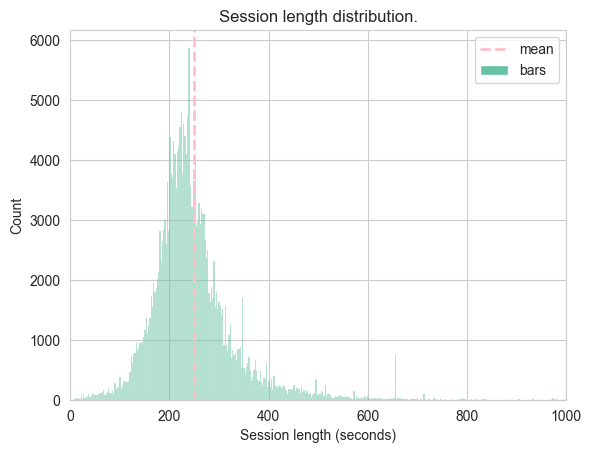

In [22]:
sns.histplot(length_session.toPandas().dropna());
# truncate the length of X axis to 1000
plt.xlim(0, 1000)
# mark the mean of the distribution
plt.axvline(length_session.agg({'length':'mean'}).collect()[0][0], color='pink', linestyle='dashed', linewidth=2)
plt.title('Session length distribution.');
# adjust legend color to match the the bars
plt.legend(['mean', 'bars']);
# title the plot
plt.xlabel('Session length (seconds)')
# save the plot
plt.savefig('img/session_length_distribution.png')

In [23]:
# Command to find out the status of the user's subsciptions, encoded in the variable `level`
levels = spark.sql('''
        SELECT level, count(DISTINCT userId) as num_users
        FROM user_table
        GROUP BY level
        ORDER BY num_users DESC
        ''')

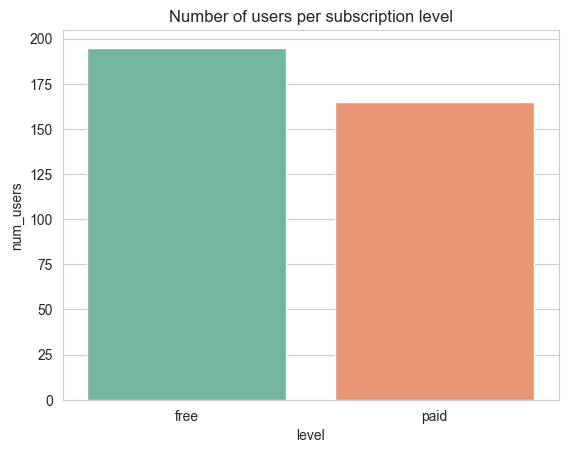

In [24]:
# plot levels
sns.barplot(x='level', y='num_users', data=levels.toPandas())
plt.title('Number of users per subscription level');
# save the plot
plt.savefig('img/num_users_per_subscription_level.png')

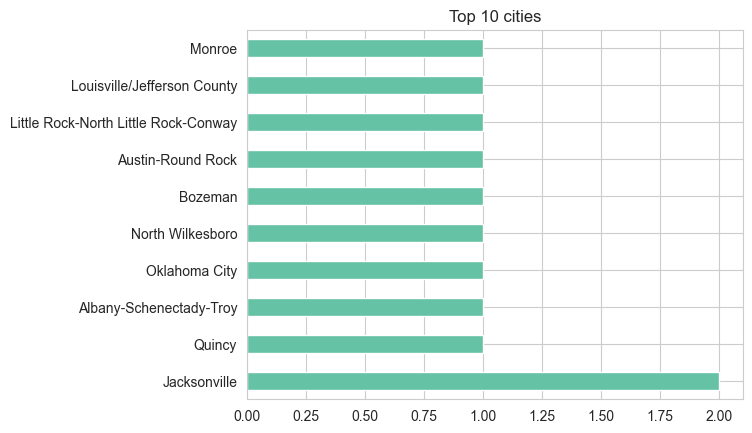

In [25]:
# get locations, their count and split it into city and state and plot
#  the top 10 cities
locations = spark.sql('''
        SELECT location, count(DISTINCT userId) as num_users
        FROM user_table
        GROUP BY location
        ORDER BY num_users DESC
        ''').toPandas()
# expand locations into city and state while preserving the num_users
expanded_locations = locations.location.str.split(',', expand=True)
expanded_locations.columns = ['city', 'state']
expanded_locations['num_users'] = locations.num_users
# plot the top 10 cities
expanded_locations.city.value_counts().head(10).plot(kind='barh')
plt.title('Top 10 cities');
# save the plot
plt.savefig('img/top_10_cities.png')
#expanded_locations.city.value_counts().head(10).plot(kind='barh')
## save the plot
#plt.savefig('img/top_10_cities.png')


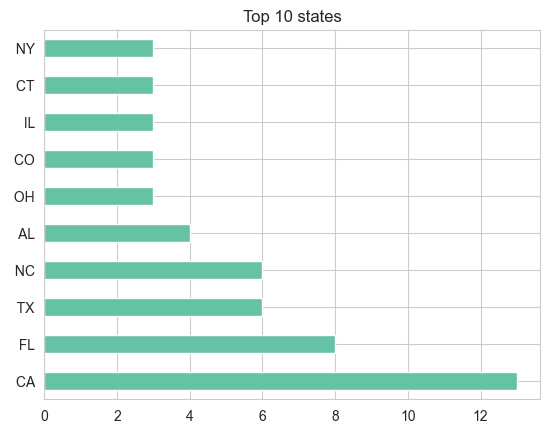

In [26]:
# get the top 10 states
expanded_locations.state.value_counts().head(10).plot(kind='barh')
# title the plot
plt.title('Top 10 states');
# save the plot
plt.savefig('img/top_10_states.png')

In [27]:
expanded_locations.head()

,city,state,num_users
0,Los Angeles-Long Beach-Anaheim,CA,16
1,New York-Newark-Jersey City,NY-NJ-PA,15
2,Phoenix-Mesa-Scottsdale,AZ,7
3,Dallas-Fort Worth-Arlington,TX,7
4,St. Louis,MO-IL,6


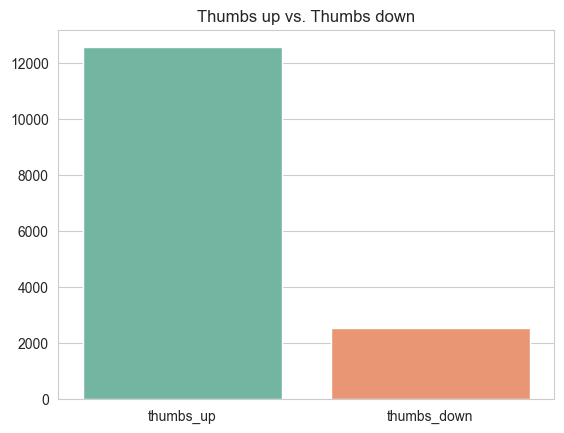

In [28]:
# get the total count of thumbs up and thumbs down
thumbs = spark.sql('''
        SELECT SUM(CASE WHEN page = 'Thumbs Up' THEN 1 ELSE 0 END) as thumbs_up,
                SUM(CASE WHEN page = 'Thumbs Down' THEN 1 ELSE 0 END) as thumbs_down
        FROM user_table
        ''').toPandas()

# plot the thumbs up and thumbs down
sns.barplot(data=thumbs)
# title the plot
plt.title('Thumbs up vs. Thumbs down');
# save the plot
plt.savefig('img/thumbs_up_vs_thumbs_down.png')


The difference is huge between thumbs up and thumbs down. It seems like the users are more likely to give a thumbs up than a thumbs down. It's expected that happy users provide more interaction with the app than unhappy users. But the difference is huge. Now I wonder if thumbs down can be an indicator of churn.

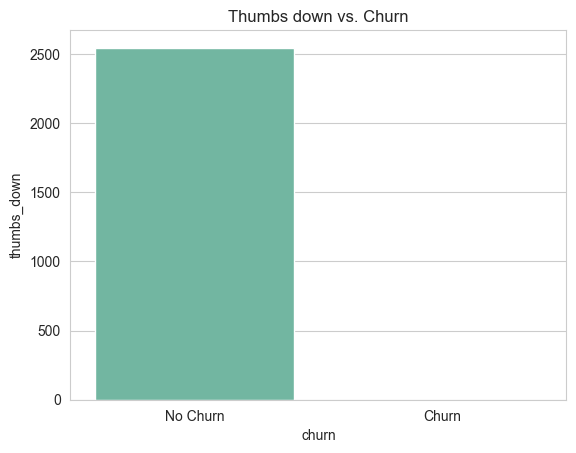

In [29]:
# check the relationship between thumbs down and churn and tabulate it
churn_vs_thumb = spark.sql('''
        SELECT churn, SUM(CASE WHEN page = 'Thumbs Down' THEN 1 ELSE 0 END) as thumbs_down
        FROM user_table
        GROUP BY churn
        ''').toPandas()
# plot the relationship
sns.barplot(x='churn', y='thumbs_down', data=churn_vs_thumb)
# title the plot
plt.title('Thumbs down vs. Churn');
# rename X axis elements as 'Churn' and 'No Churn'
plt.xticks([0, 1], ['No Churn', 'Churn'])
# save the plot
plt.savefig('img/thumbs_down_vs_churn.png')


Well, I was afraid to see this. Because this means churn behaviour is so silent that churners don't even bother interacting.

In [30]:
# the user agent variable defines the mode by which the users viewed the product - browser and platforms.
user_agents = spark.sql('''
                        SELECT userAgent, count(DISTINCT userId) as num_users
                        FROM user_table
                        GROUP BY userAgent
                        ORDER BY num_users DESC
                        ''').toPandas()

In [31]:
user_agents['userAgent'].nunique()

56

In [32]:
# infer user device from the userAgent column using sparksql and udf
def get_device(userAgent):
    '''
    Returns the device used by the user based on the userAgent column.
    
    Parameters:
    userAgent (str): the userAgent column
    
    Returns:
    str: the device used by the user
    
    '''
    if 'iPhone' in userAgent:
        return 'iPhone'
    elif 'iPad' in userAgent:
        return 'iPad'
    elif 'Android' in userAgent:
        return 'Android'
    elif 'Windows NT' in userAgent:
        return 'Windows'
    elif 'Macintosh' in userAgent:
        return 'Mac'
    else:
        return 'Other'
        

In [33]:
# register the udf
get_device_udf = udf(get_device)

# create a new column with the device
df_user = df_user.withColumn('device', get_device_udf('userAgent'))


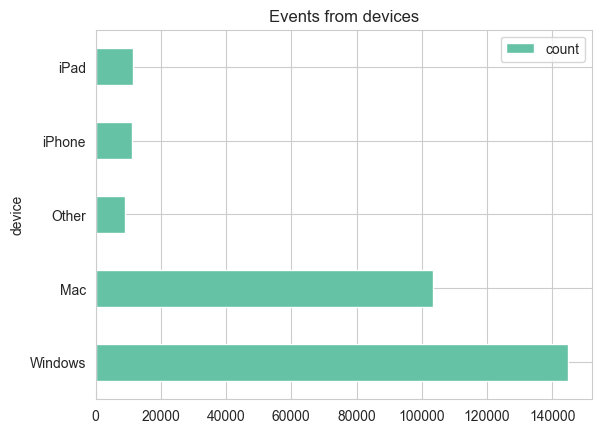

In [34]:
# plot the distribution of devices
df_user.groupBy('device').count().toPandas().plot(kind='barh', x='device', y='count')
# sort bars by count
plt.gca().invert_yaxis()
# title the plot
plt.title('Events from devices');
# save the plot
plt.savefig('img/device_distribution.png')

In [35]:
# view user_table using sparksql
df_user.createOrReplaceTempView('user_table')

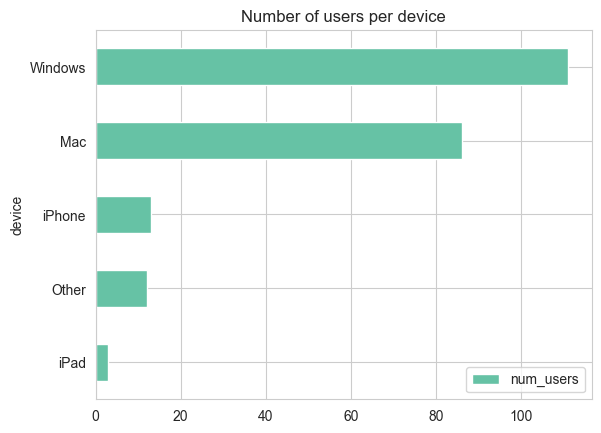

In [36]:
# get the number of users per device
spark.sql('''
        SELECT device, count(DISTINCT userId) as num_users
        FROM user_table
        GROUP BY device
        ORDER BY num_users DESC
        ''').toPandas().plot(kind='barh', x='device', y='num_users')
# sort bars by count
plt.gca().invert_yaxis()
# title the plot
plt.title('Number of users per device');
# save the plot
plt.savefig('img/num_users_per_device.png')

In [37]:
# get_browser function
def get_browser(userAgent):
    '''
    Returns the browser used by the user based on the userAgent column.
    
    Parameters:
    userAgent (str): the userAgent column
    
    Returns:
    str: the browser used by the user
    '''
    if 'Chrome' in userAgent:
        return 'Chrome'
    elif 'Firefox' in userAgent:
        return 'Firefox'
    elif 'Safari' in userAgent:
        return 'Safari'
    elif 'MSIE' in userAgent:
        return 'IE'
    elif 'Trident' in userAgent:
        return 'IE'
    elif 'rv' in userAgent:
        return 'IE'
    else:
        return 'Other'


In [38]:
# register the udf
get_browser_udf = udf(get_browser)

# create a new column with the browser
df_user = df_user.withColumn('browser', get_browser_udf('userAgent'))


In [39]:
df_user.createOrReplaceTempView('user_table')

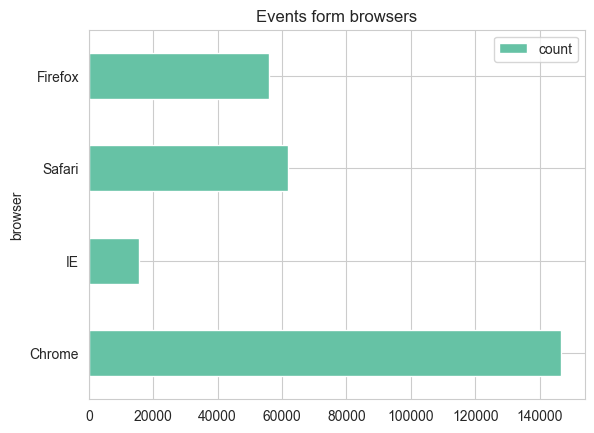

In [40]:
# plot the distribution of browsers
df_user.groupBy('browser').count().toPandas().plot(kind='barh', x='browser', y='count')
# sort bars by count
plt.gca().invert_yaxis()
# title the plot
plt.title('Events form browsers');
# save the plot
plt.savefig('img/browser_distribution.png')


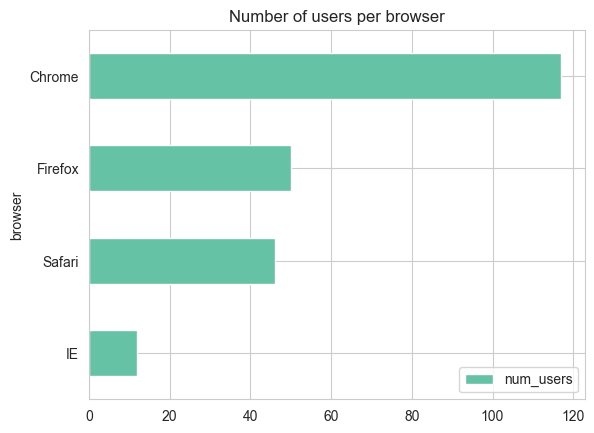

In [41]:
# get the number of users per browser
spark.sql('''
        SELECT browser, count(DISTINCT userId) as num_users
        FROM user_table
        GROUP BY browser
        ORDER BY num_users DESC
        ''').toPandas().plot(kind='barh', x='browser', y='num_users')
# sort bars by count
plt.gca().invert_yaxis()
# title the plot
plt.title('Number of users per browser');
# save the plot
plt.savefig('img/num_users_per_browser.png')

Definitely most people are using chrome

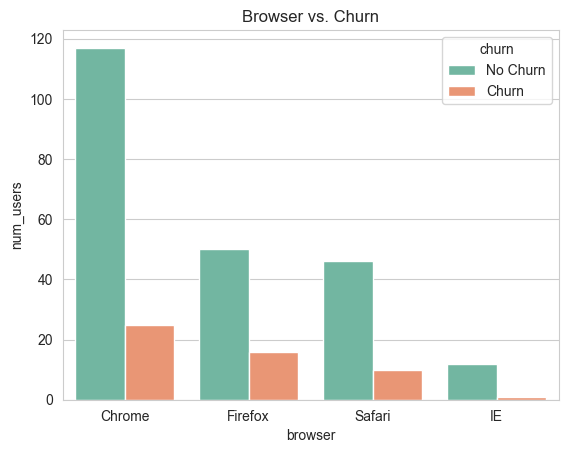

In [42]:
# plot churn vs. browser
browser_vs_churn = spark.sql('''
        SELECT browser, churn, count(DISTINCT userId) as num_users
        FROM user_table
        GROUP BY browser, churn
        ORDER BY num_users DESC
        ''').toPandas()
# plot the relationship. For churn variable recode 0 as 'No Churn' and 1 as 'Churn'
browser_vs_churn['churn'] = browser_vs_churn['churn'].replace({0: 'No Churn', 1: 'Churn'})
sns.barplot(x='browser', y='num_users', hue='churn', data=browser_vs_churn)
# title the plot
plt.title('Browser vs. Churn');
# save the plot
plt.savefig('img/browser_vs_churn.png')

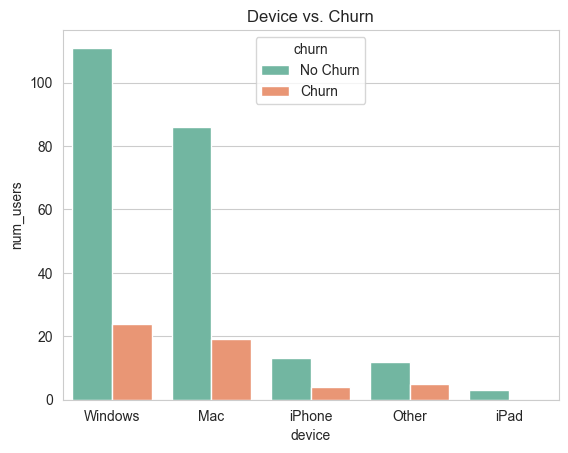

In [43]:
# plot churn vs. device
device_vs_churn = spark.sql('''
        SELECT device, churn, count(DISTINCT userId) as num_users
        FROM user_table
        GROUP BY device, churn
        ORDER BY num_users DESC
        ''').toPandas()
# plot the relationship. For churn variable recode 0 as 'No Churn' and 1 as 'Churn'
device_vs_churn['churn'] = device_vs_churn['churn'].replace({0: 'No Churn', 1: 'Churn'})
sns.barplot(x='device', y='num_users', hue='churn', data=device_vs_churn)
# title the plot
plt.title('Device vs. Churn');
# save the plot
plt.savefig('img/device_vs_churn.png')

Okay, now we are going to start working with the churn time.

In [44]:
df_user.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- cluster: long (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: double (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- fulldate: string (nullable = true)
 |-- device: string (nullable = true)
 |-- browser: string (nullable = true)



In [45]:
time_data = spark.sql('''
                    SELECT fulldate, userId
                    FROM user_table
                        ''').toPandas()

In [46]:
# function to extract time related features from the fulldate column
def get_time_features(df):
    '''
    Extracts time related features from the fulldate column.
    
    Parameters:
    df (pandas dataframe): the dataframe containing the fulldate column
    
    Returns:
    pandas dataframe: the dataframe containing the time related features
    '''
    # convert the fulldate column to datetime
    df['fulldate'] = pd.to_datetime(df['fulldate'])
    # extract the hour, day, week of year, month, year, and weekday from the fulldate column
    df['hour'] = df['fulldate'].dt.hour
    df['day'] = df['fulldate'].dt.day
    df['week'] = df['fulldate'].dt.isocalendar().week
    df['month'] = df['fulldate'].dt.month
    df['year'] = df['fulldate'].dt.year
    df['weekday'] = df['fulldate'].dt.weekday
    # weekday human readable format
    df['weekday_hrf'] = df['weekday'].replace({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})
    
    return df

# get the time related features
time_data = get_time_features(time_data)

In [47]:
time_data.head()

,fulldate,userId,hour,day,week,month,year,weekday,weekday_hrf
0,2018-10-01 02:01:57,30,2,1,40,10,2018,0,Monday
1,2018-10-01 02:03:00,9,2,1,40,10,2018,0,Monday
2,2018-10-01 02:06:34,30,2,1,40,10,2018,0,Monday
3,2018-10-01 02:06:56,9,2,1,40,10,2018,0,Monday
4,2018-10-01 02:11:16,30,2,1,40,10,2018,0,Monday


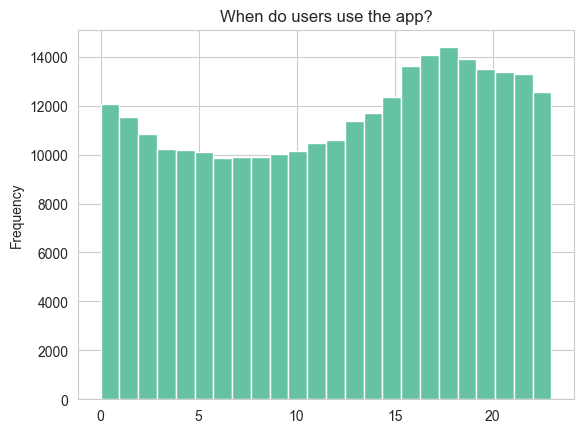

In [48]:
# plot the distribution of the hour
time_data['hour'].plot(kind='hist', bins=24)
# title the plot
plt.title('When do users use the app?');
# save the plot
plt.savefig('img/hour_distribution.png')


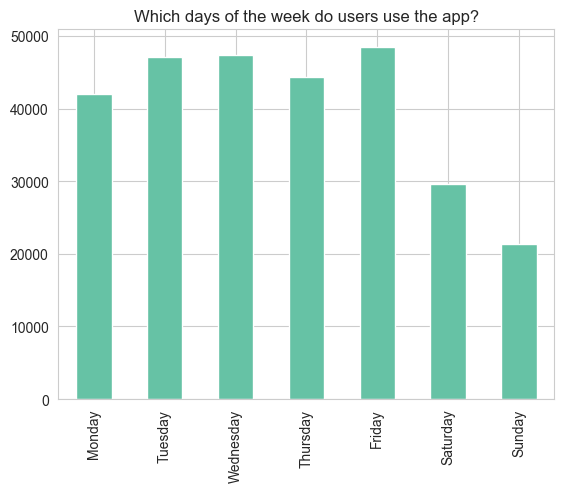

In [49]:
# which days of the week do users use the app?
# sort the values by the day of the week
time_data['weekday_hrf'] = pd.Categorical(time_data['weekday_hrf'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
time_data['weekday_hrf'].value_counts(sort=False).plot(kind='bar')
# title the plot
plt.title('Which days of the week do users use the app?');
# save the plot
plt.savefig('img/weekday_distribution.png')

The usage is really low at the weekend.

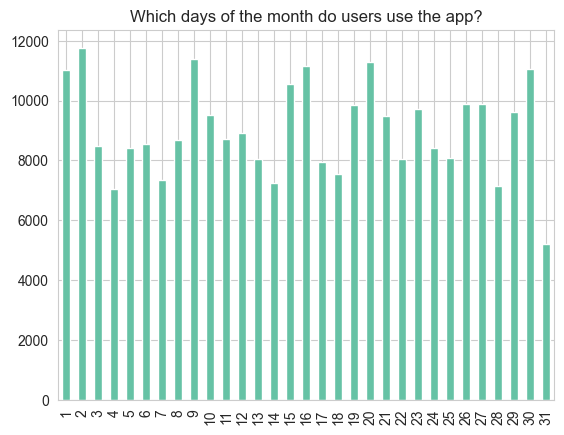

In [50]:
# which days of the month do users use the app?
# sort the values by the day of the month
time_data['day'] = pd.Categorical(time_data['day'], categories=sorted(time_data['day'].unique()), ordered=True)
# plot the distribution of the day
time_data['day'].value_counts(sort=False).plot(kind='bar')
# title the plot
plt.title('Which days of the month do users use the app?');
# save the plot
plt.savefig('img/day_distribution.png')


Well, the last plot is pretty unmeaningful but I wanted to see anyway

In [51]:
# add the time related features to the user table using spark
time_data = spark.createDataFrame(time_data)
df_user = df_user.join(time_data, on=['userId', 'fulldate'], how='left')

/Users/tugberk/DataspellProjects/capstone_sparkify/.venv/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/Users/tugberk/DataspellProjects/capstone_sparkify/.venv/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [52]:
# user table
df_user.createOrReplaceTempView('user_table')

23/01/01 11:37:48 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [53]:
# convert registration to datetime
df_user = df_user.withColumn('registration_dt', ts_todate('registration'))


In [54]:
# get the number of days since registration at event time
df_user = df_user.withColumn('ds_reg_at_event', datediff('fulldate', 'registration_dt'))


In [55]:
# user table
df_user.createOrReplaceTempView('user_table')

In [56]:
# get the number of days since registration per user and make it a column
ds_reg_at_event = spark.sql('''
                                SELECT userId, ds_reg_at_event
                                FROM user_table
                                ''').toPandas()
ds_reg_at_event = ds_reg_at_event.drop_duplicates(subset='userId', keep='last')



23/01/01 11:38:05 WARN TaskSetManager: Stage 150 contains a task of very large size (1116 KiB). The maximum recommended task size is 1000 KiB.


In [57]:
# rename the column
ds_reg_at_event = ds_reg_at_event.rename(columns={'ds_reg_at_event': 'ds_reg'})
ds_reg_at_event = spark.createDataFrame(ds_reg_at_event)
# add the days since registration column to the user table
df_user = df_user.join(ds_reg_at_event, on='userId', how='left')
# user table
df_user.createOrReplaceTempView('user_table')
ds_reg_at_event.toPandas().head()

/Users/tugberk/DataspellProjects/capstone_sparkify/.venv/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/Users/tugberk/DataspellProjects/capstone_sparkify/.venv/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


,userId,ds_reg
0,135,72
1,32,21
2,18,38
3,19,22
4,125,72


In [58]:
#print the schema
df_user.printSchema()

root
 |-- userId: string (nullable = true)
 |-- fulldate: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- cluster: long (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: double (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- device: string (nullable = true)
 |-- browser: string (nullable = true)
 |-- hour: long (nullable = true)
 |-- day: long (nullable = true)
 |-- week: long (nullable = true)
 |-- month: lo

In [59]:
# plot the distribution of the days since registration for churned users and non-churned users
temp = spark.sql('''
                    SELECT churn, ds_reg
                    FROM user_table''').toPandas()


23/01/01 11:38:51 WARN TaskSetManager: Stage 157 contains a task of very large size (1116 KiB). The maximum recommended task size is 1000 KiB.


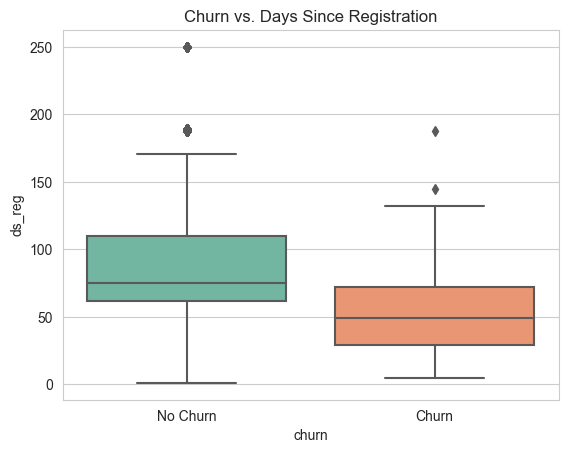

In [60]:
# churn vs. days since registration
sns.boxplot(x='churn', y='ds_reg', data=temp)
# rename churn labels
plt.xticks([0, 1], ['No Churn', 'Churn'])
# title the plot
plt.title('Churn vs. Days Since Registration');
# save the plot
plt.savefig('img/churn_vs_ds_reg.png')


Until here, we have explored the data and added new features. However, this operation was costly in terms of memory. So I will save the data to my S3 bucket and then read it from there. This will save me from the memory issues.

In [61]:
# save the data to a json file in my s3 bucket
#df_user.write.json('s3://udacitysparkify/final_df_processed.json')

In [62]:
# save the data to local disk (uncomment the line below only when you work locally)
df_user.toPandas().to_json('data/final_df_processed.json', orient='records', lines=True)

23/01/01 11:39:16 WARN TaskSetManager: Stage 166 contains a task of very large size (1116 KiB). The maximum recommended task size is 1000 KiB.
